In [1]:
%load_ext autoreload
%autoreload 2

In [109]:
from src.constants import (COLUMNS_TO_SCALE, FILE_PATH, FORECAST_SIZE,
                           NUM_FEATURES, TARGET, WINDOW_SIZE)
from src.extract_data import load_data, process_data
from src.metrics import compute_metrics
from src.models.select_model import get_model
from src.scaler import Scaler
from src.utils import build_time_series, split_train_val_test

import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

/tmp/ipykernel_29/2521744741.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [115]:
df = load_data(FILE_PATH)
df = process_data(df, use_covariates=False)
train_df, val_df, test_df = split_train_val_test(df, split_size_val=0.3, split_size_test=0.1)
scaler = Scaler(columns_to_scale=COLUMNS_TO_SCALE, target=TARGET)

train_df = scaler.fit_transform(train_df)
val_df = scaler.transform(val_df)
test_df = scaler.transform(test_df)

train_x, train_y = build_time_series(
    data=train_df, target=TARGET, window_size=WINDOW_SIZE, forecast_size=FORECAST_SIZE
)
val_x, val_y = build_time_series(data=val_df, target=TARGET, window_size=WINDOW_SIZE, forecast_size=FORECAST_SIZE)
test_x, test_y = build_time_series(
    data=test_df, target=TARGET, window_size=WINDOW_SIZE, forecast_size=FORECAST_SIZE
)

Training data shape : (639, 2)
Validation data shape : (182, 2)
Testing data shape : (92, 2) 

# Rolling windows : 585 of shape : (50, 2)
# Rolling windows : 128 of shape : (50, 2)
# Rolling windows : 38 of shape : (50, 2)


In [116]:
model_name = 'lstm'
model = get_model(
    model_name=model_name,
    target=TARGET,
    forecast_size=FORECAST_SIZE,
    num_features=NUM_FEATURES,
)

history = model.fit(train_x, train_y, val_x, val_y)


Training model...

Epoch 1/500
10/10 - 2s - loss: 0.8165 - mean_absolute_error: 0.7902 - val_loss: 0.5329 - val_mean_absolute_error: 0.6350
Epoch 2/500
10/10 - 0s - loss: 0.6012 - mean_absolute_error: 0.6631 - val_loss: 0.4972 - val_mean_absolute_error: 0.6038
Epoch 3/500
10/10 - 0s - loss: 0.5604 - mean_absolute_error: 0.6304 - val_loss: 0.4615 - val_mean_absolute_error: 0.5822
Epoch 4/500
10/10 - 0s - loss: 0.5321 - mean_absolute_error: 0.6064 - val_loss: 0.4353 - val_mean_absolute_error: 0.5637
Epoch 5/500
10/10 - 0s - loss: 0.5076 - mean_absolute_error: 0.6027 - val_loss: 0.4066 - val_mean_absolute_error: 0.5409
Epoch 6/500
10/10 - 0s - loss: 0.4791 - mean_absolute_error: 0.5770 - val_loss: 0.3805 - val_mean_absolute_error: 0.5027
Epoch 7/500
10/10 - 0s - loss: 0.4477 - mean_absolute_error: 0.5545 - val_loss: 0.3509 - val_mean_absolute_error: 0.4818
Epoch 8/500
10/10 - 0s - loss: 0.4139 - mean_absolute_error: 0.5213 - val_loss: 0.3156 - val_mean_absolute_error: 0.4587
Epoch 9/500


In [117]:
preds = model.predict(test_x)
compute_metrics(test_y, preds)

MAPE : 142.56 %
MSE : 0.14
MAE : 0.25


(1.4255794021954904, 0.13667458877028432, 0.24688598583146315)

In [113]:
preds = scaler.inverse_transform(preds)
test_y = scaler.inverse_transform(test_y)
test_x = scaler.inverse_transform(test_x)

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

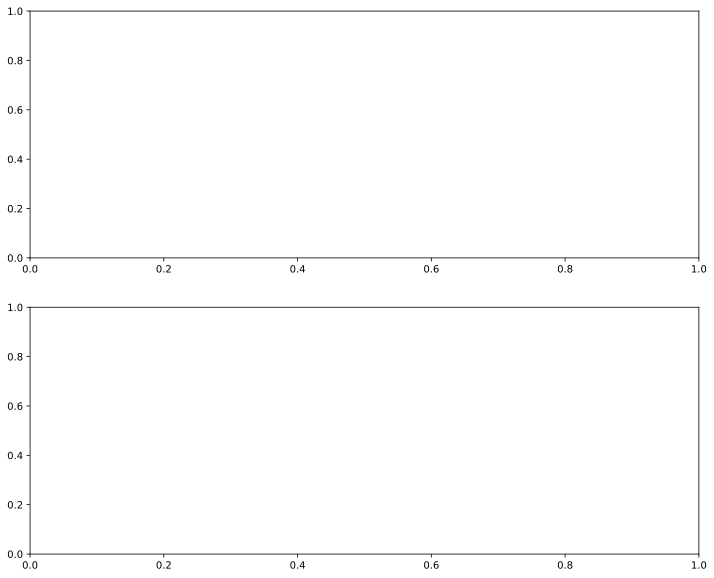

In [114]:
def plot(pred, test_y_sample, test_x_sample):
    fig, ax = plt.subplots(pred.shape[1], 1, figsize=(12,10))
    
    for col in pred.columns:
        ax.plot(test_x_sample.index, test_x_sample[col].values, marker='.', label='Input')
        ax.scatter(test_y_sample.index, test_y_sample[col].values, edgecolors='k', label='Labels', c='#2ca02c', s=64)        
        ax.scatter(pred.index, pred[col].values,  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
    plt.legend()

idx = -1
plot(preds[idx], test_y[idx], test_x[idx])

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


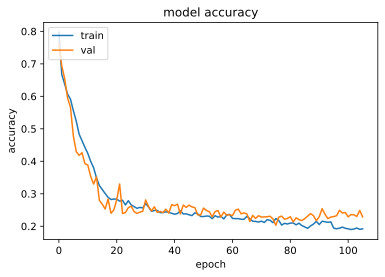

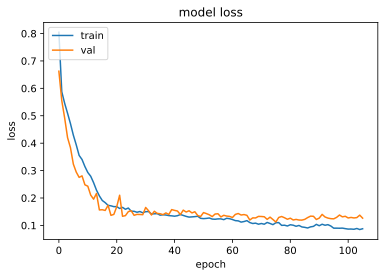

In [105]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()